# Coursework Template

**Dependencies and imports**

This can take a minute...

In [1]:
# !pip install swig
# !pip install --upgrade rldurham

In [2]:
import torch
import rldurham as rld

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import deque

**Reinforcement learning agent**

Replace this with your own agent, I recommend starting with TD3 (lecture 8).

In [3]:
class RunningMeanStd:
    def __init__(self, shape=()):
        self.mean = np.zeros(shape, dtype=np.float32)
        self.var = np.ones(shape, dtype=np.float32)
        self.count = 1e-4
        
    def update(self, x):
        batch_mean = np.mean(x, axis=0)
        batch_var = np.var(x, axis=0)
        batch_count = x.shape[0]
        
        delta = batch_mean - self.mean
        self.mean = self.mean + delta * batch_count / (self.count + batch_count)
        m_a = self.var * self.count
        m_b = batch_var * batch_count
        M2 = m_a + m_b + np.square(delta) * self.count * batch_count / (self.count + batch_count)
        self.var = M2 / (self.count + batch_count)
        self.count = self.count + batch_count

In [4]:
class Agent(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        super(Agent, self).__init__()
        
        # Simple policy network (actor)
        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim),
            nn.Tanh()  # Bound actions to [-1, 1]
        )
        
        # Simple value network (critic)
        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        
        # Initialize with smaller weights for better initial exploration
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                nn.init.orthogonal_(layer.weight, 0.1)
                layer.bias.data.zero_()
        
        # Training parameters
        self.trajectory = []
        self.optimizer = torch.optim.Adam([
            {'params': self.actor.parameters(), 'lr': 3e-4},
            {'params': self.critic.parameters(), 'lr': 1e-3}
        ])
        
        # Hyperparameters
        self.gamma = 0.99  # Discount factor
        self.exploration_noise = 0.1  # Initial exploration noise
        self.min_exploration_noise = 0.02  # Minimum exploration noise
        self.exploration_decay = 0.995  # Decay rate for exploration
        
        # Statistics
        self.running_rewards = deque(maxlen=100)
        self.episode_count = 0
    
    def sample_action(self, state):
        """Sample action with noise for exploration"""
        state = torch.FloatTensor(state)
        with torch.no_grad():
            # Get deterministic action from policy
            action = self.actor(state)
            
            # Add noise for exploration
            noise = torch.randn_like(action) * self.exploration_noise
            action = torch.clamp(action + noise, -1.0, 1.0)
            
        return action.numpy()
    
    def put_data(self, state, action, reward, next_state, done):
        """Store transition in memory"""
        self.trajectory.append((state, action, reward, next_state, done))
    
    def train(self):
        """Update policy and value networks"""
        if len(self.trajectory) < 1:
            return
        
        # Unpack trajectories
        states, actions, rewards, next_states, dones = zip(*self.trajectory)
        
        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.FloatTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        # Compute returns and advantages
        with torch.no_grad():
            next_values = self.critic(next_states).squeeze()
            current_values = self.critic(states).squeeze()
            
            # Compute TD targets and advantages
            td_targets = rewards + self.gamma * next_values * (1 - dones)
            advantages = td_targets - current_values
        
        # Normalize advantages
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        # Compute actor (policy) loss
        # We want to maximize advantage, so we minimize negative advantage
        policy_loss = -(advantages.detach() * (actions - self.actor(states)).pow(2).sum(1)).mean()
        
        # Compute critic (value) loss using MSE
        value_loss = F.mse_loss(self.critic(states).squeeze(), td_targets.detach())
        
        # Combined loss
        total_loss = policy_loss + value_loss
        
        # Update networks
        self.optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.5)
        self.optimizer.step()
        
        # Decay exploration noise
        self.exploration_noise = max(
            self.min_exploration_noise,
            self.exploration_noise * self.exploration_decay
        )
        
        # Clear trajectory
        self.trajectory = []
        self.episode_count += 1
        
        return total_loss.item()
    
    def update_stats(self, episode_reward):
        """Update running statistics"""
        self.running_rewards.append(episode_reward)
        
    def get_average_reward(self):
        """Get average reward over last 100 episodes"""
        return np.mean(self.running_rewards) if self.running_rewards else 0

**Prepare the environment and wrap it to capture statistics, logs, and videos**

The device is: cpu (as recommended)
actions are continuous with 4 dimensions/#actions
observations are continuous with 24 dimensions/#observations
maximum timesteps is: None


/home/billy/.local/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/billy/Github/ReinforcementLearning/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


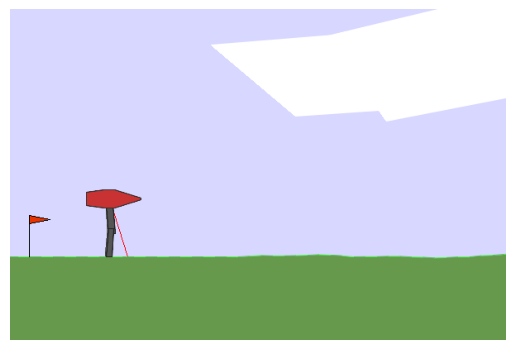

In [5]:
env = rld.make("rldurham/Walker", render_mode="rgb_array")
# env = rld.make("rldurham/Walker", render_mode="rgb_array", hardcore=True) # only attempt this when your agent has solved the non-hardcore version

# get statistics, logs, and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (useful for plotting)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos (replace xxxx00 with your username)
    logs=True,                          # keep logs
)

# training on CPU recommended
rld.check_device()

# environment info
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env, print_out=True)

# render start image
env.reset(seed=42)
rld.render(env)

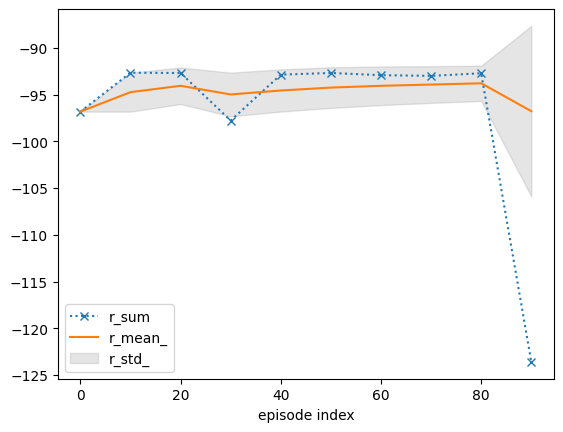

In [6]:
# in the submission please use seed_everything with seed 42 for verification
seed, observation, info = rld.seed_everything(42, env)

# initialise agent
agent = Agent(env.observation_space.shape[0], env.action_space.shape[0])
max_episodes = 100
max_timesteps = 2000

# track statistics for plotting
tracker = rld.InfoTracker()

# switch video recording off (only switch on every x episodes as this is slow)
env.video = False

# training procedure
for episode in range(max_episodes):
    
    # recording statistics and video can be switched on and off (video recording is slow!)
    env.info = episode % 10 == 0   # track every x episodes (usually tracking every episode is fine)
    env.video = episode % 10 == 0  # record videos every x episodes (set BEFORE calling reset!)

    # reset for new episode
    observation, info = env.reset()
    episode_reward = 0
    
    for t in range(max_timesteps):
    
        action = agent.sample_action(observation)
        next_observation, reward, terminated, truncated, info = env.step(action)
        
        episode_reward += reward
        done = terminated or truncated
            
        agent.put_data(observation, action, reward, next_observation, done)
        
        observation = next_observation
        
        if done:
            break
        
    loss = agent.train()
    agent.update_stats(episode_reward)

    # TRAIN THE AGENT HERE!
            
    # track and plot statistics
    tracker.track(info)
    if (episode + 1) % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True, r_sum=dict(linestyle=':', marker='x'))

# don't forget to close environment (e.g. triggers last video save)
env.close()

# write log file (for coursework)
env.write_log(folder="logs", file="xxxx00-agent-log.txt")  # replace xxxx00 with your username

A small demo with a predefined heuristic that is suboptimal and has no notion of balance (and is designed for the orignal BipedalWalker environment)...

In [7]:
from gymnasium.envs.box2d.bipedal_walker import BipedalWalkerHeuristics

env = rld.make(
    "rldurham/Walker",
    # "BipedalWalker-v3",
    render_mode="human",
    # render_mode="rgb_array",
    hardcore=False,
    # hardcore=True,
)
_, obs, info = rld.seed_everything(42, env)

heuristics = BipedalWalkerHeuristics()

act = heuristics.step_heuristic(obs)
for _ in range(500):
    obs, rew, terminated, truncated, info = env.step(act)
    act = heuristics.step_heuristic(obs)
    if terminated or truncated:
        break
    if env.render_mode == "rgb_array":
        rld.render(env, clear=True)
env.close()

Seed set to 42
